In [1]:
from scipy.optimize import minimize
import corner
import ptemcee
import subprocess
import pandas as pd
from joblib import Parallel, delayed

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import SIMS.run_simple_energy_loss_parallel as eloss
import GPy

In [3]:
simulation=eloss.run_simulation

In [4]:
pT_range = (1, 10, 10) # Compute more observable than needed to avoid boundry unstabilities.
pT_obs = [3, 5, 7] # p_T Observables we will use for the analysis

In [5]:
from emukit.core import ParameterSpace, ContinuousParameter

In [6]:
# old prior ranges
#prior_ranges= {'alpha_s':(0.05,0.5), 'exponent_inel':(-3,3), 'exponent_el':(-3,3), 'scale_inel':(0.1, 0.5), 'scale_el':(0.1, 0.5)}

prior_ranges= {'alpha_s':(0.1,0.4), 'exponent_inel':(-2,2), 'exponent_el':(-2,2), 'scale_inel':(0.1, 0.4), 'scale_el':(0.1, 0.4)}
true_values= {'alpha_s': 0.2, 'exponent_inel': -1, 'exponent_el': 1, 'scale_inel': 0.3, 'scale_el': 0.3}
name_to_position =  {'alpha_s':0, 'exponent_inel':1, 'exponent_el':2, 'scale_inel':3, 'scale_el':4}

In [7]:
# We will generate observable for these model parametr values and consider them as experimental data
# We will generate observables for these model parameter values and consider them as experimental data
truth = np.array([true_values['alpha_s'],  true_values['exponent_inel'],
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']]).reshape(1,-1)

Text(0.5, 1.0, 'Experimental observations')

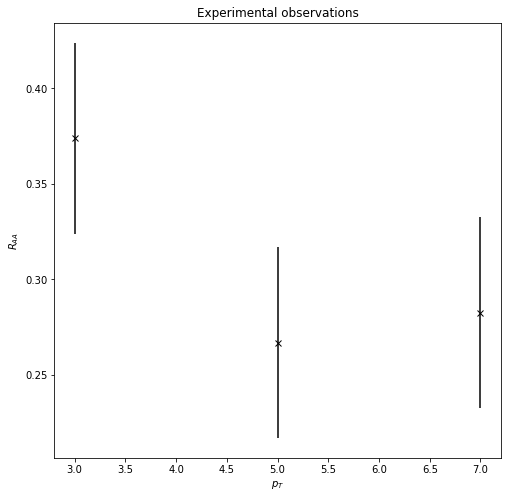

In [8]:
# Set seed for reproducibility.
seed = 42
np.random.seed(seed)

# Generate some synthetic data from the model.
x = np.array(pT_obs)
N = len(x)
obserr = 0.05 # Amplitude of noise term
obs = simulation(truth, *pT_range)[:,pT_obs] # True model
obs += obserr * np.random.randn(N) # Add some random noise

# Now plot it to see what the data looks like
fig, ax = plt.subplots(figsize=(8,8))

ax.errorbar(x.flatten(), obs.flatten(), yerr=obserr, fmt="xk", capsize=0)
#ax.plot(x.flatten(), obs.flatten(), "k", alpha=0.3, lw=3)
#ax.set_xlim(0, 10)
ax.set_xlabel(r"$p_T$")
ax.set_ylabel(r"$R_{AA}$")
ax.set_title('Experimental observations')

In [9]:
parameter_space = ParameterSpace([ContinuousParameter('alpha_s', 0.1,0.4 ),
                                  ContinuousParameter('exponent_inel', -2, 2),
                                  ContinuousParameter('exponent_el', -2, 2),
                                  ContinuousParameter('scale_inel', 0.1, 0.4),
                                  ContinuousParameter('scale_el', 0.1, 0.4)])

In [10]:
from emukit.core.initial_designs import LatinDesign

design = LatinDesign(parameter_space)
num_data_points = 20
X = design.get_samples(num_data_points)
print(f'Shape of X {X.shape}')

Shape of X (20, 5)


In [11]:
# Define the loglikelihood function
def logLikelihood(theta, x, obs, obserr):
  
    # Model parameters
    theta = np.array(theta)
    
    #alpha_s, mD_factor, exponent_inel, exponent_el = theta
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta
    design = np.array([alpha_s, exp_inel, exp_el, sc_inel, sc_el]).reshape(1,-1)
    
    # Model predictions given parameters
    
    model = simulation(design,*pT_range)[:,x]#np.array([emu_predict0(design),emu_predict1(design),emu_predict2(design)],dtype=object)
    modelerr = np.array(0)#model[:,1]
    #model = model[:,0]
    
    # Likelihood of data given model parameters

    term2 = 0.5*(2*np.pi*np.sqrt(np.sum(obserr**2+modelerr.flatten()**2)))
    return -0.5*np.sum((obs.flatten()-model.flatten())**2/(obserr**2+modelerr.flatten()**2)) - term2

In [12]:
# Define the loglikelihood function
def Likelihood(theta, x, obs, obserr):
  
    # Model parameters
    theta = np.array(theta)
    
    #alpha_s, mD_factor, exponent_inel, exponent_el = theta
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta
    design = np.array([alpha_s, exp_inel, exp_el, sc_inel, sc_el]).reshape(1,-1)
    
    # Model predictions given parameters
    
    model = simulation(design,*pT_range)[:,x]#np.array([emu_predict0(design),emu_predict1(design),emu_predict2(design)],dtype=object)
    modelerr = np.array(0)#model[:,1]
    #model = model[:,0]
    
    # Likelihood of data given model parameters

    term2 = 0.5*(2*np.pi*np.sqrt(np.sum(obserr**2+modelerr.flatten()**2)))
    return np.exp(-0.5*np.sum((obs.flatten()-model.flatten())**2/(obserr**2+modelerr.flatten()**2)) - term2)

In [44]:
def fl(design, pT=pT_obs):
    """returns likelihood function for a design matrix"""
    print(design)
    cores = 4
    like = Parallel(n_jobs=cores)(delayed(Likelihood)(theta, np.array(pT), obs, obserr) for theta in design)
#     like = [logLikelihood(theta, np.array(pT), obs, obserr) for theta in design]
    #observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    #return observables[:,pT]
    return np.array(like).reshape(-1,1)

def fll(design, pT=pT_obs):
    """returns likelihood function for a design matrix"""
    print(design)
    cores = 4
    like = Parallel(n_jobs=cores)(delayed(logLikelihood)(theta, np.array(pT), obs, obserr) for theta in design)
#     like = [logLikelihood(theta, np.array(pT), obs, obserr) for theta in design]
    #observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    #return observables[:,pT]
    return np.array(like).reshape(-1,1)

def f1(design, pT=pT_obs[0]):
    """returns simulation output for a design matrix"""
    print(design)
    observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    return observables[:,pT].reshape(-1,1)

def f2(design, pT=pT_obs[1]):
    """returns simulation output for a design matrix"""
    print(design)
    observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    return observables[:,pT].reshape(-1,1)

def f3(design, pT=pT_obs[2]):
    """returns simulation output for a design matrix"""
    print(design)
    observables=simulation(design,*pT_range)
    #Let's just return only one obsrvable for now. The middle p_T bin
    return observables[:,pT].reshape(-1,1)

fun=np.array([f1, f2, f3])
funl = np.array([fl])
funll = np.array([fll])

In [14]:
# simplistic memoization to speed up repeated corner plot calculations. 
# Generally should have a way to avoid these entirely rather than demand batch-by-batch uniqueness

# doesn't handle ndarrays well

#def memoize(f):
#    memo = {}
#    def helper(x):
#        if x not in memo:            
#            memo[x] = f(x)
#        return memo[x]
#    return helper
#
#fll = memoize(fll)
#funll = np.array([fll])

In [171]:
#Generate 5 random observables
Y = fll(X,pT_obs)

[[ 0.1525 -1.7     0.1     0.3775  0.2125]
 [ 0.2725 -1.5     1.5     0.1525  0.1075]
 [ 0.3175 -0.9     0.9     0.1075  0.3925]
 [ 0.2875  0.9     1.3     0.1375  0.3175]
 [ 0.3925  1.9    -0.5     0.2425  0.2875]
 [ 0.1225 -0.5    -0.9     0.3325  0.1525]
 [ 0.3475  1.1    -0.3     0.3925  0.1375]
 [ 0.2425 -0.3     0.7     0.2725  0.2275]
 [ 0.3025  0.1     1.7     0.1825  0.3625]
 [ 0.2275  1.7    -1.3     0.1975  0.1825]
 [ 0.1825  1.5    -1.1     0.2125  0.1225]
 [ 0.1975 -0.7     0.5     0.3025  0.3325]
 [ 0.2575  0.3    -1.7     0.3175  0.1675]
 [ 0.3625  1.3    -0.1     0.2575  0.3775]
 [ 0.1675  0.7     1.1     0.1225  0.2425]
 [ 0.3325 -1.9    -1.5     0.1675  0.2725]
 [ 0.1075  0.5    -0.7     0.3475  0.3025]
 [ 0.2125 -0.1    -1.9     0.2875  0.1975]
 [ 0.1375 -1.3     1.9     0.3625  0.3475]
 [ 0.3775 -1.1     0.3     0.2275  0.2575]]


In [172]:
Y

array([[  -0.41624299],
       [ -15.83087388],
       [ -19.77698194],
       [ -25.18867347],
       [ -46.44277848],
       [ -73.16200081],
       [ -27.21579818],
       [  -5.1723037 ],
       [ -24.01821053],
       [  -0.55203823],
       [ -18.0293631 ],
       [  -0.54604153],
       [  -5.67708779],
       [ -38.71777804],
       [ -15.05607095],
       [ -43.52698861],
       [-127.47830251],
       [  -0.3515501 ],
       [ -18.16708799],
       [ -53.48852463]])

In [173]:
np.save('initial-likelihood-gp-X-smallpriors-20pts',X)
np.save('initial-likelihood-gp-Y-smallpriors-20pts',Y)

In [253]:
X = np.load('initial-likelihood-gp-X-smallpriors-20pts.npy')
Y = np.load('initial-likelihood-gp-Y-smallpriors-20pts.npy')

In [254]:
from GPy.kern import RBF, White
from GPy.models import GPRegression
from emukit.model_wrappers import GPyModelWrapper
#from multiprocessing import Pool

In [255]:
import emukit
emukit.experimental_design.acquisitions.__file__

'/home/mheffernan/Desktop/McGill/Research/PhD/Code/emukit/emukit/experimental_design/acquisitions/__init__.py'

## Time to get emulating

In [256]:
# size of possible variation of parameters
ptp = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])\
-np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])

gp_array = []

#lengthscale = [0.08827045, 3.68405746, 380.55348423, 0.30696173, 1.38426181 ]
lengthscale = [0.08827045, 0.368405746, 0.155348423, 0.30696173, 0.38426181 ]
# for i,pt in enumerate(pT_obs):
rbf_kern =      RBF(  input_dim=5,
                      variance= 0.1,
                      lengthscale=lengthscale,
                      ARD=True)
my_kernel = rbf_kern
model_gpy = GPRegression(X=X,Y=Y.reshape(-1,1),kernel=my_kernel, noise_var=1e-2)
#model_gpy.optimize('bfgs', max_iters=200)
#for i in range(len(ptp)):
length_prior = GPy.core.parameterization.priors.Uniform(0.,10)

#model_gpy.kern.lengthscale.set_prior(length_prior)

#model_gpy.kern.lengthscale.constrain_bounded(0.,5,warning=False ) 

#model_gpy.optimize_restarts(num_restarts = 30)
model_emukit = GPyModelWrapper(model_gpy, n_restarts=50)
gp_array.append(model_emukit)

In [257]:
model_emukit.model

GP_regression.,value,constraints,priors
rbf.variance,0.1,+ve,
rbf.lengthscale,"(5,)",+ve,
Gaussian_noise.variance,0.01,+ve,


In [258]:
## Set some priors to make life better
#model_emukit.model.Gaussian_noise.variance.constrain_bounded(0,75,warning=False)#set_prior(GPy.core.parameterization.priors.Uniform(0.,5))
#model_emukit.model.rbf.variance.constrain_bounded(0,75,warning=False)#set_prior(GPy.core.parameterization.priors.Uniform(0.,5))
#model_emukit.model.rbf.lengthscale.constrain_bounded(0,5,warning=False)

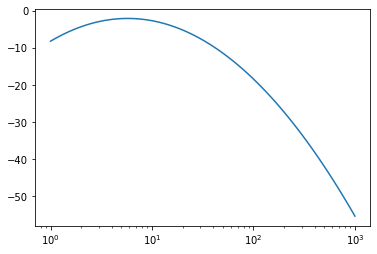

In [259]:
plt.figure()
xs = np.logspace(0,3,100)
priory = np.log(GPy.core.parameterization.priors.LogGaussian(2,.5).pdf(xs))
plt.plot(xs,priory)
plt.xscale('log')
plt.show()
#GPy.core.parameterization.priors.InverseGamma(-0.035391,1.97737108)

In [260]:
## Set some priors to make life better
model_emukit.model.Gaussian_noise.variance.set_prior(GPy.core.parameterization.priors.LogGaussian(2,.5))
model_emukit.model.rbf.variance.set_prior(GPy.core.parameterization.priors.LogGaussian(2,.5))
model_emukit.model.rbf.lengthscale.set_prior(GPy.core.parameterization.priors.LogGaussian(1,.5))

In [261]:
model_emukit.model

GP_regression.,value,constraints,priors
rbf.variance,0.1,+ve,"lnN(2, 0.5)"
rbf.lengthscale,"(5,)",+ve,"lnN(1, 0.5)"
Gaussian_noise.variance,0.01,+ve,"lnN(2, 0.5)"


In [262]:
model_emukit.model.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.08827045,+ve,"lnN(1, 0.5)"
[1],0.36840575,+ve,"lnN(1, 0.5)"
[2],0.15534842,+ve,"lnN(1, 0.5)"
[3],0.30696173,+ve,"lnN(1, 0.5)"
[4],0.38426181,+ve,"lnN(1, 0.5)"


In [221]:
cov = model_gpy.posterior_covariance_between_points(X[0].reshape(1,-1),X)

In [222]:
cornerpoint = np.array([ 0.1,  2., -2.,  0.4, 0.1]).reshape(1,-1)
tr = np.array([0.2, -1, 1, 0.3, 0.3]).reshape(1,-1)
prediction = model_gpy.predict(tr)
prediction_corner = model_gpy.predict(cornerpoint)

variance_prediction = np.sqrt((np.exp(prediction[0])*prediction[1])**2)
variance_prediction_corner = np.sqrt((np.exp(prediction_corner[0])*prediction_corner[1])**2)

In [223]:
print(np.mean(cov**2/variance_prediction_corner)*np.exp(prediction_corner[0]))
print(np.mean(cov**2/variance_prediction)*np.exp(prediction[0]))

[[3.7565713e-05]]
[[3.97507623e-05]]


In [224]:
print(np.mean(np.exp(prediction[0])))
print(np.mean(np.exp(prediction_corner[0])))

0.009327981854974084
1.0000330091365617


In [263]:
from emukit.experimental_design.acquisitions import IntegratedExponentiatedVarianceReduction, ModelExpVariance
#from emukit.experimental_design.acquisitions importlib.reload(IntegratedExponentiatedVarianceReduction, ModelExpVariance)
from emukit.experimental_design import ExperimentalDesignLoop

In [264]:
#test_method = IntegratedExponentiatedVarianceReduction(model = model_emukit, space=parameter_space)
test_method = ModelExpVariance(model = model_emukit)

In [265]:
print(test_method.evaluate(tr))
print(test_method.evaluate(cornerpoint))

[[0.00096968]]
[[0.11000363]]


In [266]:
mean, variance = model_emukit.predict(cornerpoint)
        #return np.exp(2*mean + variance**2)*(np.exp(variance**2)-1) #Kandasamy utility function
np.exp(2*mean + variance**2)*(np.exp(variance**2)-1) 

array([[0.01232251]])

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [114]:
for i in range(0,1):
    print(f'loop {i}')
    expdesign_loop = ExperimentalDesignLoop(model = model_emukit,
                                         space = parameter_space,
                                         acquisition = test_method,
                                         batch_size = 10)
    ed=expdesign_loop.run_loop(funll[0],1)
    print(model_emukit.model)
    print(model_emukit.model.rbf.lengthscale)

loop 0
Optimization restart 1/50, f = 285.984710407391
Optimization restart 2/50, f = 327.7180810523301
Optimization restart 3/50, f = 299.1404407872403
Optimization restart 4/50, f = 290.8250875608398
Optimization restart 5/50, f = 290.825086465056
Optimization restart 6/50, f = 290.82508650540706
Optimization restart 7/50, f = 290.82508646721095
Optimization restart 8/50, f = 290.8250865198588
Optimization restart 9/50, f = 290.8250865255803
Optimization restart 10/50, f = 292.37934664562397
Optimization restart 11/50, f = 290.8250864650015
Optimization restart 12/50, f = 400.88581824296546
Optimization restart 13/50, f = 290.82508647981786
Optimization restart 14/50, f = 290.8250864656585
Optimization restart 15/50, f = 290.8250864649833
Optimization restart 16/50, f = 290.82508647101406
Optimization restart 17/50, f = 290.8250864683499
Optimization restart 18/50, f = 311.57156073243
Optimization restart 19/50, f = 290.8250864651757
Optimization restart 20/50, f = 309.58852929669
Op

In [91]:
print(model_emukit.model)
print(model_emukit.model.rbf.lengthscale)


Name : GP regression
Objective : 556.0375044607628
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |    priors   
  rbf.variance             |  1052.668274722701  |      +ve      |  lnN(2, 0.5)
  rbf.lengthscale          |               (5,)  |      +ve      |  lnN(1, 0.5)
  Gaussian_noise.variance  |  69.12142884187823  |      +ve      |  lnN(2, 0.5)
  index  |  GP_regression.rbf.lengthscale  |  constraints  |    priors   
  [0]    |                     0.07006086  |      +ve      |  lnN(1, 0.5)
  [1]    |                     2.36924267  |      +ve      |  lnN(1, 0.5)
  [2]    |                    10.79541786  |      +ve      |  lnN(1, 0.5)
  [3]    |                     0.26376858  |      +ve      |  lnN(1, 0.5)
  [4]    |                     2.10486309  |      +ve      |  lnN(1, 0.5)


In [51]:
model_emukit.X.shape

(100, 5)

In [149]:
integrated_expvar = []
for g in gp_array:
    print(g.model)
    integrated_expvar.append(IntegratedExponentiatedVarianceReduction(model = g, space=parameter_space))


Name : GP regression
Objective : 389.11769528539025
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |   value  |  constraints  |  priors
  rbf.variance             |  3000.0  |      +ve      |        
  rbf.lengthscale          |    (5,)  |      +ve      |        
  Gaussian_noise.variance  |     3.5  |      +ve      |        


In [150]:
g.model.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],0.30000000,+ve,
[1],4.00000000,+ve,
[2],4.00000000,+ve,
[3],0.30000000,+ve,
[4],0.30000000,+ve,


In [151]:
#from emukit.core.optimization import GradientAcquisitionOptimizer
#optimizer = GradientAcquisitionOptimizer(parameter_space)

In [96]:
print(X.shape)
print(Y.shape)

(50, 5)
(50, 1)


In [113]:
import time
for i in range(0,1):#range(0,10):
#model_variance = ModelVariance(model = model_emukit)
    gp = 0
    print (f'Training loop {i}')
    integrated_expvar = IntegratedExponentiatedVarianceReduction(model = gp_array[gp], space=parameter_space)
    expdesign_loop = ExperimentalDesignLoop(model = gp_array[gp],
                                         space = parameter_space,
                                         acquisition = integrated_expvar,
                                         batch_size = 10)
    ed=expdesign_loop.run_loop(funll[gp],1)

Training loop 0
Optimization restart 1/50, f = 285.98471042789515
Optimization restart 2/50, f = 290.82508646505624
Optimization restart 3/50, f = 290.8250864895858
Optimization restart 4/50, f = 285.98471055166044
Optimization restart 5/50, f = 290.8250864659772
Optimization restart 6/50, f = 290.8250864651079
Optimization restart 7/50, f = 290.8250864654848
Optimization restart 8/50, f = 290.8250864683586
Optimization restart 9/50, f = 290.825086465281
Optimization restart 10/50, f = 290.82508649222217
Optimization restart 11/50, f = 290.825086502914
Optimization restart 12/50, f = 320.8076236988056
Optimization restart 13/50, f = 290.82508646583983
Optimization restart 14/50, f = 317.58575382607546
Optimization restart 15/50, f = 290.8250864653217
Optimization restart 16/50, f = 285.9847109355313
Optimization restart 17/50, f = 290.82508646987947
Optimization restart 18/50, f = 290.82508653282565
Optimization restart 19/50, f = 290.82508646529766
Optimization restart 20/50, f = 297.

KeyboardInterrupt: 

In [155]:
integrated_expvar = []
for g in gp_array:
    print(g.model)
    integrated_expvar.append(IntegratedExponentiatedVarianceReduction(model = g, space=parameter_space))
    print(g.model.rbf.lengthscale)


Name : GP regression
Objective : 240.34902233944325
Number of Parameters : 7
Number of Optimization Parameters : 7
Updates : True
Parameters:
  GP_regression.           |              value  |  constraints  |  priors
  rbf.variance             |  4070.117008357687  |      +ve      |        
  rbf.lengthscale          |               (5,)  |      +ve      |        
  Gaussian_noise.variance  |  40.98016766717365  |      +ve      |        
  index  |  GP_regression.rbf.lengthscale  |  constraints  |  priors
  [0]    |                     0.08827045  |      +ve      |        
  [1]    |                     3.68405746  |      +ve      |        
  [2]    |                   380.55348423  |      +ve      |        
  [3]    |                     0.30696173  |      +ve      |        
  [4]    |                     1.38426181  |      +ve      |        


In [80]:
# I think the step below is unnecessary and the GP will already be trained on these points. So after this run, stop.

In [81]:
X_latest=gp_array[0].X#[-10:,:]
# we want to train the GP based on the exponentiated LogLikelihood function
#Y_latest= fll(X_latest, pT=pT_obs)

In [82]:
Y_latest=gp_array[0].Y

In [83]:
Y_latest

ObsAr([[ -95.83457821],
       [ -47.88302328],
       [ -13.76754085],
       [ -57.94531199],
       [  -2.26316647],
       [ -23.97148064],
       [-106.6940879 ],
       [ -25.471655  ],
       [ -55.82507311],
       [  -9.54342995],
       [ -37.1975214 ],
       [  -9.00997284],
       [ -15.24284442],
       [ -46.3994795 ],
       [ -31.79565709],
       [  -4.57003692],
       [  -1.88860005],
       [  -0.66278658],
       [ -36.64941604],
       [ -83.66715079],
       [  -7.55390726],
       [ -31.74021899],
       [ -82.65651519],
       [ -66.66581128],
       [ -15.32448673],
       [ -50.51296345],
       [ -51.40253706],
       [ -53.60363774],
       [ -48.2033054 ],
       [ -49.13253605],
       [ -40.17882132],
       [ -24.70095626],
       [ -37.58575575],
       [ -20.97191618],
       [ -11.38618761],
       [  -1.7152277 ],
       [  -4.61963394],
       [ -41.62139676],
       [ -20.69828064],
       [-121.90193224],
       [  -1.8057471 ],
       [ -11.912

In [84]:
gp_array[0].X


ObsAr([[ 0.127     ,  0.84      ,  1.56      ,  0.229     ,  0.349     ],
       [ 0.379     ,  0.44      ,  0.84      ,  0.331     ,  0.145     ],
       [ 0.211     ,  1.16      , -1.48      ,  0.391     ,  0.103     ],
       [ 0.355     , -1.8       , -0.84      ,  0.379     ,  0.133     ],
       [ 0.223     ,  1.48      , -1.56      ,  0.241     ,  0.109     ],
       [ 0.313     , -1.16      , -0.04      ,  0.133     ,  0.301     ],
       [ 0.133     ,  1.56      ,  0.68      ,  0.325     ,  0.373     ],
       [ 0.301     , -0.04      , -1.32      ,  0.193     ,  0.163     ],
       [ 0.385     , -1.48      , -0.6       ,  0.259     ,  0.361     ],
       [ 0.163     ,  0.04      , -1.8       ,  0.181     ,  0.391     ],
       [ 0.325     ,  0.12      , -0.68      ,  0.349     ,  0.271     ],
       [ 0.187     ,  1.8       , -1.4       ,  0.217     ,  0.283     ],
       [ 0.277     ,  1.88      ,  0.52      ,  0.187     ,  0.205     ],
       [ 0.307     ,  1.        , -1.1

In [85]:
X = X_latest#np.append(gp_array[0].X, X_latest, axis=0)
            
Y = Y_latest.reshape(-1,1)#np.append(gp_array[0].Y, Y_latest.reshape(-1,1), axis=0)
print(X.shape)
print(Y.shape)

(60, 5)
(60, 1)


In [85]:
X = model_gpy.X#np.append(gp_array[0].X, X_latest, axis=0)
            
Y = Y_latest.reshape(-1,1)#np.append(gp_array[0].Y, Y_latest.reshape(-1,1), axis=0)
print(X.shape)
print(Y.shape)

(60, 5)
(60, 1)


In [52]:
np.save('likelihood-gp-X-100pts-maxexpvar-20ptLHS-lognormpriors',model_emukit.X)
np.save('likelihood-gp-Y-100pts-maxexpvar-20ptLHS-lognormpriors',model_emukit.Y)

In [267]:
def emu_predictl(X):
    y, variance_dy = model_emukit.predict(X)
    dy = np.sqrt(variance_dy)
    #y = scaler_0.inverse_transform(scaled_y)
    #dy = scaled_dy* scaler_0.scale_
    return y, dy.flatten()

In [268]:
def utility(x):
    """
    x: parameter set to predict
    
    returns
    --------
    utility function that says how useful this point is
    
    In this case, naive exponentiated variance
    """
    gp_y0, gp_dy0 = emu_predictl(x)
    return np.sqrt((np.exp(gp_y0)*gp_dy0)**2)

In [269]:
def find_useful_points(num_adapt_points=2500,N=20):
    """
    num_adapt_points: number of points to probe the space with
    N: number of new points per round
    
    returns
    --------
    x_new_to_keep: new parameters that have a large utility
    
    """
    
    # same parameter space as defined previously
    adapt = LatinDesign(parameter_space) 
    X_new = adapt.get_samples(num_adapt_points)
    
    # same utility function as before
    utility_at_x_new = np.array([utility(np.array([x])) for x in X_new]).reshape(1,-1).flatten()
    
    K = utility_at_x_new.copy() # copy just to stay safe
    #store list in tmp to retrieve index
    tmp=list(K)
    K.sort()
    
    list_of_indices = [tmp.index(K[-i]) for i in range(N)]
    x_new_to_keep = np.array([X_new[list_of_indices[i]] for i in range(N)])
    
    return x_new_to_keep
    

In [270]:
def matt_design_loop():
    """
    Design loop that attempts to find points that are useful
    """
    
    model_emukit.optimize() # fit our GP to start
    xnew = find_useful_points()
    ynew = fll(xnew) # calculate the new points
    print(ynew)
    X_update = np.vstack((np.array(model_emukit.X),xnew)) # concatenate arrays
    Y_update = np.vstack((np.array(model_emukit.Y),ynew))
    model_emukit.set_data(X_update,Y_update) # update GP model dataset
    model_emukit.optimize() # reoptimize

In [271]:
for i in range(0,4):
    print(f'Loop {i}')
    matt_design_loop()

Loop 0
Optimization restart 1/50, f = 161.31574196598828
Optimization restart 2/50, f = 161.31574196862195
Optimization restart 3/50, f = 166.2004575882301
Optimization restart 4/50, f = 167.0376143156218
Optimization restart 5/50, f = 161.3157419671368
Optimization restart 6/50, f = 161.3157419706078
Optimization restart 7/50, f = 161.31574196585976
Optimization restart 8/50, f = 161.3157419713964
Optimization restart 9/50, f = 168.18769055534523
Optimization restart 10/50, f = 161.31574196645025
Optimization restart 11/50, f = 161.31574228742528
Optimization restart 12/50, f = 161.31574199210453
Optimization restart 13/50, f = 161.31574196592408
Optimization restart 14/50, f = 161.3157419669648
Optimization restart 15/50, f = 161.31574197049582
Optimization restart 16/50, f = 161.3157419746872
Optimization restart 17/50, f = 161.31574196595247
Optimization restart 18/50, f = 161.31574196608167
Optimization restart 19/50, f = 161.315741970332
Optimization restart 20/50, f = 161.315741

Optimization restart 41/50, f = 287.67136743530466
Optimization restart 42/50, f = 303.762430889792
Optimization restart 43/50, f = 287.67136742485275
Optimization restart 44/50, f = 303.7624329617006
Optimization restart 45/50, f = 308.11791257535106
Optimization restart 46/50, f = 303.76243088922547
Optimization restart 47/50, f = 305.46328403327965
Optimization restart 48/50, f = 303.76243119201513
Optimization restart 49/50, f = 305.64932437405275
Optimization restart 50/50, f = 287.67136742282617
[[ 0.1381  0.196   1.06    0.1975  0.1753]
 [ 0.1687 -1.78   -1.916   0.3799  0.2779]
 [ 0.3475 -1.908  -1.82    0.1423  0.2983]
 [ 0.1351 -1.764  -1.908   0.3163  0.2947]
 [ 0.1189 -1.732  -1.9     0.2959  0.3871]
 [ 0.3937 -1.468  -1.94    0.3679  0.1339]
 [ 0.2317  1.964  -1.876   0.1195  0.2989]
 [ 0.3391 -1.58   -1.884   0.2869  0.2713]
 [ 0.3913 -1.66   -1.764   0.1435  0.1273]
 [ 0.2119  1.828  -1.852   0.3973  0.3217]
 [ 0.2785 -1.268  -1.932   0.3841  0.1585]
 [ 0.2425  1.78   -1

Optimization restart 9/50, f = 487.94368993806336
Optimization restart 10/50, f = 526.5155054768552
Optimization restart 11/50, f = 483.2207852864681
Optimization restart 12/50, f = 436.6960454120616
Optimization restart 13/50, f = 427.9540303443873
Optimization restart 14/50, f = 418.4849023851455
Optimization restart 15/50, f = 483.22078526689364
Optimization restart 16/50, f = 447.30443122322976
Optimization restart 17/50, f = 495.6065238696386
Optimization restart 18/50, f = 485.7469631294381
Optimization restart 19/50, f = 437.75775563228547
Optimization restart 20/50, f = 432.24708813851635
Optimization restart 21/50, f = 481.8846948755453
Optimization restart 22/50, f = 485.71649982364755
Optimization restart 23/50, f = 418.48490480170597
Optimization restart 24/50, f = 418.4849024885803
Optimization restart 25/50, f = 479.31028019231707
Optimization restart 26/50, f = 418.4851647685017
Optimization restart 27/50, f = 525.5685277160856
Optimization restart 28/50, f = 490.0571358

Optimization restart 49/50, f = 459.07945748097916
Optimization restart 50/50, f = 536.0707537860694


In [272]:
model_emukit.X.shape

(100, 5)

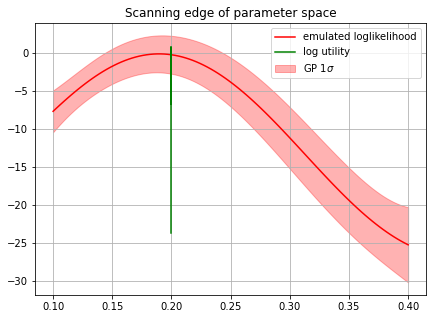

In [277]:
plt.figure(figsize=(7,5))

# let's visualize on some edges

# emutestpts = np.array([[x,-1.99,1.99,0.3,0.3] for x in \
#                        np.linspace(prior_ranges['alpha_s'][0],prior_ranges['alpha_s'][1],n_plot_pts)])


emutestpts = np.array([[0.2,x,1.99,0.3,0.3] for x in \
                       np.linspace(-2,2,n_plot_pts)])
gp_y0, gp_dy0 = emu_predictl(emutestpts)

#print(emu_predictl(np.array([emutestpts[0]])))
#print(utility(np.array([x for x in emutestpts])))

util_pts = np.array([utility(np.array([x]))  for x in emutestpts]).reshape(1,-1).flatten()

#print(np.array(util_pts).reshape(1,-1).flatten())

plt.plot(test_points[:,0], gp_y0[:,0], color='red', label='emulated loglikelihood')
plt.fill_between(test_points[:,0], y1 = gp_y0[:,0] - 1.*gp_dy0, y2 = gp_y0[:,0] + 1.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

# plt.plot(emutestpts[:,0], np.exp(gp_y0[:,0]), color='red', label='emulated likelihood')
# plt.fill_between(emutestpts[:,0], y1 = np.exp(gp_y0[:,0]) - 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), y2 = np.exp(gp_y0[:,0]) + 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), 
#                  interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.plot(emutestpts[:,0], np.log(util_pts), color='green', label='log utility')

plt.title('Scanning edge of parameter space')
plt.grid(True)
plt.legend()

plt.show()

In [48]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points = np.array([[x,true_values['exponent_inel'],
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['alpha_s'][0],prior_ranges['alpha_s'][1],n_plot_pts)])
simulation_out = fll(test_points[np.arange(0,n_plot_pts,sim_pnt),:],pT=pT_obs)#[:,pT_obs]

[[ 0.1        -1.          1.          0.3         0.3       ]
 [ 0.13030303 -1.          1.          0.3         0.3       ]
 [ 0.16060606 -1.          1.          0.3         0.3       ]
 [ 0.19090909 -1.          1.          0.3         0.3       ]
 [ 0.22121212 -1.          1.          0.3         0.3       ]
 [ 0.25151515 -1.          1.          0.3         0.3       ]
 [ 0.28181818 -1.          1.          0.3         0.3       ]
 [ 0.31212121 -1.          1.          0.3         0.3       ]
 [ 0.34242424 -1.          1.          0.3         0.3       ]
 [ 0.37272727 -1.          1.          0.3         0.3       ]]


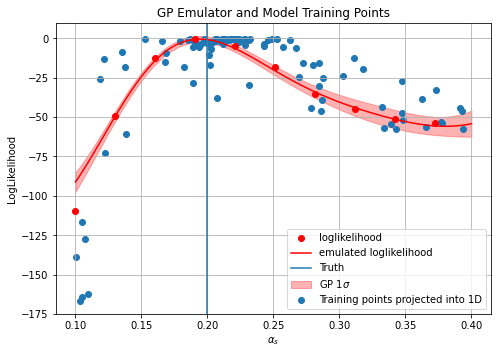

In [278]:
plt.figure(figsize=(7,5))

plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),0], simulation_out[:,0],'ro', label='loglikelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points)

plt.plot(test_points[:,0], gp_y0[:,0], color='red', label='emulated loglikelihood')
plt.fill_between(test_points[:,0], y1 = gp_y0[:,0] - 1.*gp_dy0, y2 = gp_y0[:,0] + 1.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.scatter(model_emukit.X[:,0],model_emukit.Y,label='Training points projected into 1D')

plt.axvline(true_values['alpha_s'],label='Truth')

plt.xlabel(r'$\alpha_s$')
plt.ylabel(r'LogLikelihood')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.grid(True)
plt.tight_layout(True)

plt.show()

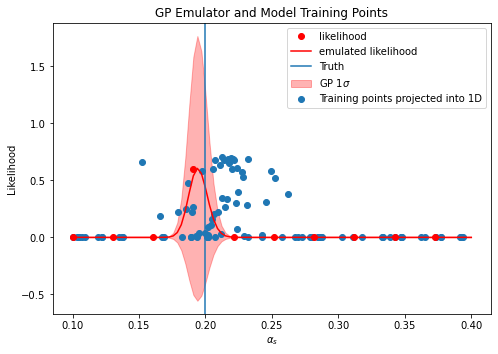

In [279]:
plt.figure(figsize=(7,5))
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),0], np.exp(simulation_out[:,0]),'ro', label='likelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points)

plt.plot(test_points[:,0], np.exp(gp_y0[:,0]), color='red', label='emulated likelihood')
plt.fill_between(test_points[:,0], y1 = np.exp(gp_y0[:,0]) - 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), y2 = np.exp(gp_y0[:,0]) + 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.axvline(true_values['alpha_s'],label='Truth')
plt.scatter(gp_array[0].X[:,0],np.exp(gp_array[0].Y),label='Training points projected into 1D')

plt.xlabel(r'$\alpha_s$')
plt.ylabel(r'Likelihood')
plt.title(r'GP Emulator and Model Training Points')
#plt.ylim(0,1)
plt.legend()
plt.tight_layout(True)

plt.show()

In [49]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points2 = np.array([[true_values['alpha_s'],x,
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['exponent_inel'][0],prior_ranges['exponent_inel'][1],n_plot_pts)])
simulation_out2 = fll(test_points2[np.arange(0,n_plot_pts,sim_pnt),:],pT=pT_obs)#[:,pT_obs]

[[ 0.2        -2.          1.          0.3         0.3       ]
 [ 0.2        -1.5959596   1.          0.3         0.3       ]
 [ 0.2        -1.19191919  1.          0.3         0.3       ]
 [ 0.2        -0.78787879  1.          0.3         0.3       ]
 [ 0.2        -0.38383838  1.          0.3         0.3       ]
 [ 0.2         0.02020202  1.          0.3         0.3       ]
 [ 0.2         0.42424242  1.          0.3         0.3       ]
 [ 0.2         0.82828283  1.          0.3         0.3       ]
 [ 0.2         1.23232323  1.          0.3         0.3       ]
 [ 0.2         1.63636364  1.          0.3         0.3       ]]


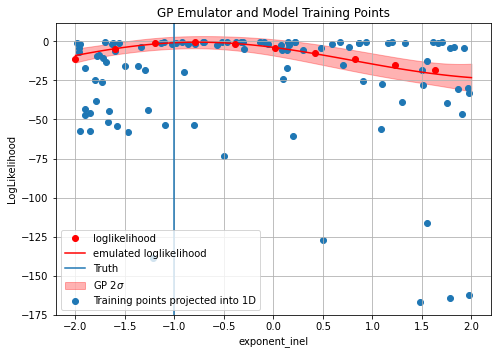

In [280]:
plt.figure(figsize=(7,5))

plt.plot(test_points2[np.arange(0,n_plot_pts,sim_pnt),1], simulation_out2[:,0],'ro', label='loglikelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points2)

plt.plot(test_points2[:,1], gp_y0[:,0], color='red', label='emulated loglikelihood')
plt.fill_between(test_points2[:,1], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')

plt.scatter(gp_array[0].X[:,1],gp_array[0].Y,label='Training points projected into 1D')

plt.axvline(true_values['exponent_inel'],label='Truth')

plt.xlabel(r'exponent_inel')
plt.ylabel(r'LogLikelihood')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.grid(True)
plt.tight_layout(True)

plt.show()

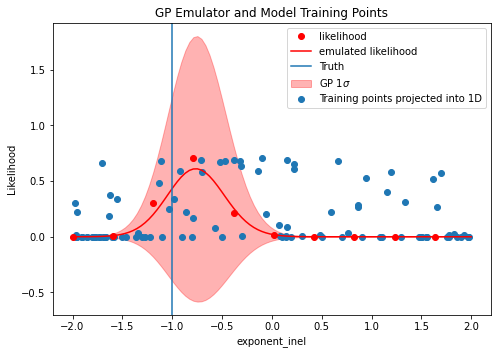

In [281]:
plt.figure(figsize=(7,5))
plt.plot(test_points2[np.arange(0,n_plot_pts,sim_pnt),1], np.exp(simulation_out2[:,0]),'ro', label='likelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points2)

plt.plot(test_points2[:,1], np.exp(gp_y0[:,0]), color='red', label='emulated likelihood')
plt.fill_between(test_points2[:,1], y1 = np.exp(gp_y0[:,0]) - 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), y2 = np.exp(gp_y0[:,0]) + 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.axvline(true_values['exponent_inel'],label='Truth')
plt.scatter(gp_array[0].X[:,1],np.exp(gp_array[0].Y),label='Training points projected into 1D')

plt.xlabel(r'exponent_inel')
plt.ylabel(r'Likelihood')
plt.title(r'GP Emulator and Model Training Points')
#plt.ylim(0,1)
plt.legend()
plt.tight_layout(True)

plt.show()

In [50]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points3 = np.array([[true_values['alpha_s'],true_values['exponent_inel'],x,
                 true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['exponent_el'][0],prior_ranges['exponent_el'][1],n_plot_pts)])
simulation_out3 = fll(test_points3[np.arange(0,n_plot_pts,sim_pnt),:],pT=pT_obs)#[:,pT_obs]

[[ 0.2        -1.         -2.          0.3         0.3       ]
 [ 0.2        -1.         -1.5959596   0.3         0.3       ]
 [ 0.2        -1.         -1.19191919  0.3         0.3       ]
 [ 0.2        -1.         -0.78787879  0.3         0.3       ]
 [ 0.2        -1.         -0.38383838  0.3         0.3       ]
 [ 0.2        -1.          0.02020202  0.3         0.3       ]
 [ 0.2        -1.          0.42424242  0.3         0.3       ]
 [ 0.2        -1.          0.82828283  0.3         0.3       ]
 [ 0.2        -1.          1.23232323  0.3         0.3       ]
 [ 0.2        -1.          1.63636364  0.3         0.3       ]]


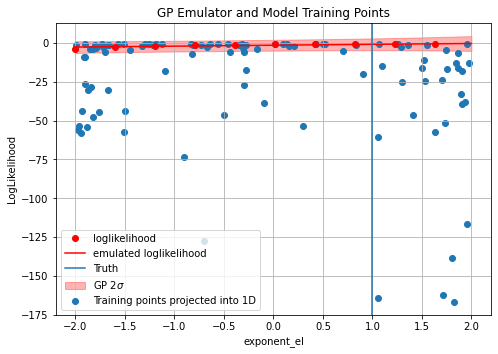

In [282]:
plt.figure(figsize=(7,5))

plt.plot(test_points3[np.arange(0,n_plot_pts,sim_pnt),2], simulation_out3[:,0],'ro', label='loglikelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points3)

plt.plot(test_points3[:,2], gp_y0[:,0], color='red', label='emulated loglikelihood')
plt.fill_between(test_points3[:,2], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')

plt.scatter(gp_array[0].X[:,2],gp_array[0].Y,label='Training points projected into 1D')

plt.axvline(true_values['exponent_el'],label='Truth')

plt.xlabel(r'exponent_el')
plt.ylabel(r'LogLikelihood')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.grid(True)
plt.tight_layout(True)

plt.show()

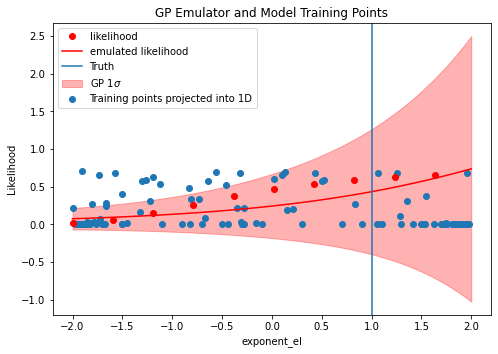

In [283]:
plt.figure(figsize=(7,5))
plt.plot(test_points3[np.arange(0,n_plot_pts,sim_pnt),2], np.exp(simulation_out3[:,0]),'ro', label='likelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points3)

plt.plot(test_points3[:,2], np.exp(gp_y0[:,0]), color='red', label='emulated likelihood')
plt.fill_between(test_points3[:,2], y1 = np.exp(gp_y0[:,0]) - 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), y2 = np.exp(gp_y0[:,0]) + 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.axvline(true_values['exponent_el'],label='Truth')
plt.scatter(gp_array[0].X[:,2],np.exp(gp_array[0].Y),label='Training points projected into 1D')

plt.xlabel(r'exponent_el')
plt.ylabel(r'Likelihood')
plt.title(r'GP Emulator and Model Training Points')
#plt.ylim(0,1)
plt.legend()
plt.tight_layout(True)

plt.show()

In [51]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points4 = np.array([[true_values['alpha_s'],true_values['exponent_inel'],true_values['exponent_el'],
                 x,true_values['scale_el']] for x in np.linspace(prior_ranges['scale_inel'][0],prior_ranges['scale_inel'][1],n_plot_pts)])
simulation_out4 = fll(test_points4[np.arange(0,n_plot_pts,sim_pnt),:],pT=pT_obs)#[:,pT_obs]

[[ 0.2        -1.          1.          0.1         0.3       ]
 [ 0.2        -1.          1.          0.13030303  0.3       ]
 [ 0.2        -1.          1.          0.16060606  0.3       ]
 [ 0.2        -1.          1.          0.19090909  0.3       ]
 [ 0.2        -1.          1.          0.22121212  0.3       ]
 [ 0.2        -1.          1.          0.25151515  0.3       ]
 [ 0.2        -1.          1.          0.28181818  0.3       ]
 [ 0.2        -1.          1.          0.31212121  0.3       ]
 [ 0.2        -1.          1.          0.34242424  0.3       ]
 [ 0.2        -1.          1.          0.37272727  0.3       ]]


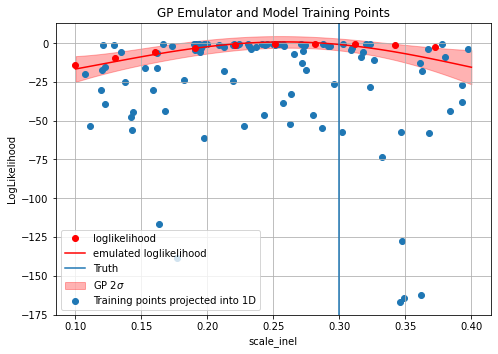

In [284]:
plt.figure(figsize=(7,5))

plt.plot(test_points4[np.arange(0,n_plot_pts,sim_pnt),3], simulation_out4[:,0],'ro', label='loglikelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points4)

plt.plot(test_points4[:,3], gp_y0[:,0], color='red', label='emulated loglikelihood')
plt.fill_between(test_points4[:,3], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')

plt.scatter(gp_array[0].X[:,3],gp_array[0].Y,label='Training points projected into 1D')

plt.axvline(true_values['scale_inel'],label='Truth')

plt.xlabel(r'scale_inel')
plt.ylabel(r'LogLikelihood')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.grid(True)
plt.tight_layout(True)

plt.show()

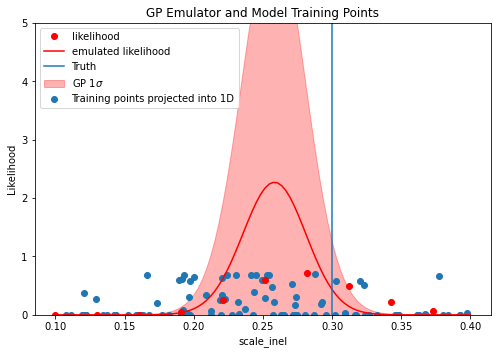

In [287]:
plt.figure(figsize=(7,5))
plt.plot(test_points4[np.arange(0,n_plot_pts,sim_pnt),3], np.exp(simulation_out4[:,0]),'ro', label='likelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points4)

plt.plot(test_points4[:,3], np.exp(gp_y0[:,0]), color='red', label='emulated likelihood')
plt.fill_between(test_points4[:,3], y1 = np.exp(gp_y0[:,0]) - 1.*np.exp(2*gp_y0[:,0] + gp_dy0**2)*(np.exp(gp_dy0**2)-1), y2 = np.exp(gp_y0[:,0]) + 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.axvline(true_values['scale_inel'],label='Truth')
plt.scatter(gp_array[0].X[:,3],np.exp(gp_array[0].Y),label='Training points projected into 1D')

plt.xlabel(r'scale_inel')
plt.ylabel(r'Likelihood')
plt.title(r'GP Emulator and Model Training Points')
plt.ylim(0,5)
plt.legend()
plt.tight_layout(True)

plt.show()

In [52]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points5 = np.array([[true_values['alpha_s'],true_values['exponent_inel'],true_values['exponent_el'],
                 true_values['scale_inel'],x] for x in np.linspace(prior_ranges['scale_el'][0],prior_ranges['scale_el'][1],n_plot_pts)])
simulation_out5 = fll(test_points5[np.arange(0,n_plot_pts,sim_pnt),:],pT=pT_obs)#[:,pT_obs]

[[ 0.2        -1.          1.          0.3         0.1       ]
 [ 0.2        -1.          1.          0.3         0.13030303]
 [ 0.2        -1.          1.          0.3         0.16060606]
 [ 0.2        -1.          1.          0.3         0.19090909]
 [ 0.2        -1.          1.          0.3         0.22121212]
 [ 0.2        -1.          1.          0.3         0.25151515]
 [ 0.2        -1.          1.          0.3         0.28181818]
 [ 0.2        -1.          1.          0.3         0.31212121]
 [ 0.2        -1.          1.          0.3         0.34242424]
 [ 0.2        -1.          1.          0.3         0.37272727]]


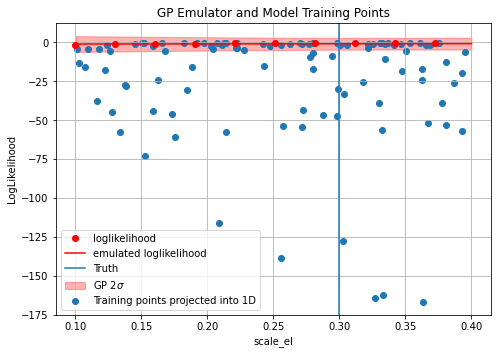

In [288]:
plt.figure(figsize=(7,5))

plt.plot(test_points5[np.arange(0,n_plot_pts,sim_pnt),4], simulation_out5[:,0],'ro', label='loglikelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points5)

plt.plot(test_points5[:,4], gp_y0[:,0], color='red', label='emulated loglikelihood')
plt.fill_between(test_points5[:,4], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')

plt.scatter(gp_array[0].X[:,4],gp_array[0].Y,label='Training points projected into 1D')

plt.axvline(true_values['scale_el'],label='Truth')

plt.xlabel(r'scale_el')
plt.ylabel(r'LogLikelihood')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.grid(True)
plt.tight_layout(True)

plt.show()

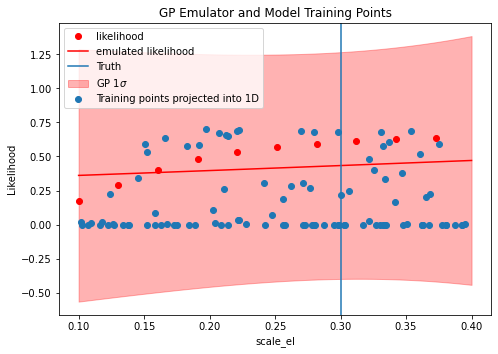

In [289]:
plt.figure(figsize=(7,5))
plt.plot(test_points5[np.arange(0,n_plot_pts,sim_pnt),4], np.exp(simulation_out5[:,0]),'ro', label='likelihood')

#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predictl(test_points5)

plt.plot(test_points5[:,4], np.exp(gp_y0[:,0]), color='red', label='emulated likelihood')
plt.fill_between(test_points5[:,4], y1 = np.exp(gp_y0[:,0]) - 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), y2 = np.exp(gp_y0[:,0]) + 1.*np.sqrt((np.exp(gp_y0[:,0])*gp_dy0)**2), 
                 interpolate=True, alpha=0.3, label=r'GP 1$\sigma$', color='red')

plt.axvline(true_values['scale_el'],label='Truth')
plt.scatter(gp_array[0].X[:,4],np.exp(gp_array[0].Y),label='Training points projected into 1D')

plt.xlabel(r'scale_el')
plt.ylabel(r'Likelihood')
plt.title(r'GP Emulator and Model Training Points')
#plt.ylim(0,1)
plt.legend()
plt.tight_layout(True)

plt.show()

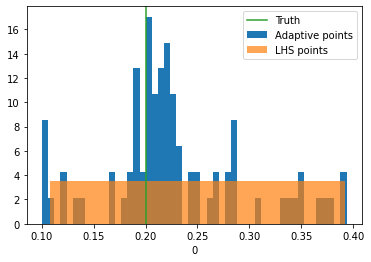

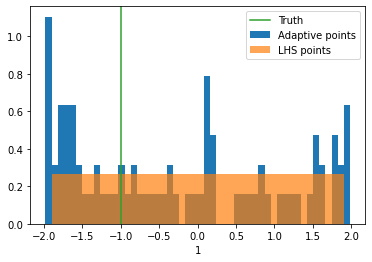

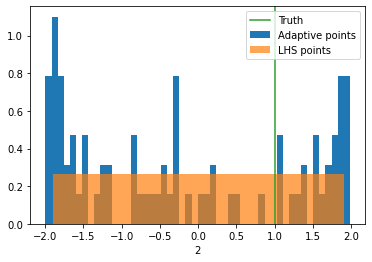

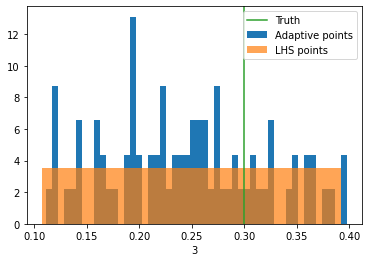

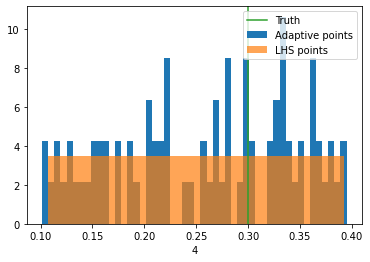

In [311]:
import matplotlib.pyplot as plt

X = model_emukit.X

for i in range(0,5):
    plt.figure()
    plt.hist(X[:,i][20:],bins=50,density=True,label='Adaptive points')
    plt.hist(X[:,i][:20],bins=20,density=True,label='LHS points',alpha=0.7)
    plt.axvline(truth[:,i],color="tab:green",label='Truth')
    
    plt.xlabel(str(i))
    plt.legend(loc=1)
    plt.show()

In [290]:
# Define the logprior function
def logPrior(theta):
    
    # Model parameters
    theta = np.array(theta)
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta 
    
    # Probability of model parameters: flat prior
    if prior_ranges['alpha_s'][0] < alpha_s < prior_ranges['alpha_s'][1] \
        and prior_ranges['exponent_inel'][0] < exp_inel < prior_ranges['exponent_inel'][1] \
        and prior_ranges['exponent_el'][0] < exp_el < prior_ranges['exponent_el'][1]\
        and prior_ranges['scale_inel'][0] < sc_inel < prior_ranges['scale_inel'][1] \
        and prior_ranges['scale_el'][0] < sc_el < prior_ranges['scale_el'][1]:
        return 0.0
    return -np.inf

In [291]:
def logemulikelihood(theta,x, obs, obserr):
    theta = theta.reshape(-1,5)
    emulike = emu_predictl(theta)#[0]
    #print(emulike)
    return emulike[0]

In [292]:
logemulikelihood(test_points5[0].reshape(-1,5),0,0,0)

array([[-1.01785137]])

In [293]:
# Define logprobability function: l(D|theta) * p(theta)
# Note: use this for emcee, not approxposterior!
def logemuposterior(theta, x, obs, obserr):
        
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logemulikelihood(theta)

In [294]:
ntemps = 25
Tmax = 1e3

nwalkers = 10 #guidance is 10*d
ndim = 5
nburnin = 200
niterations= 1500
nthin = 1#0 # only record every nthin iteration

nthreads = 4

min_theta = np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])
max_theta = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])

# Data and uncertainties that we use to condition our model
args = (x, obs, obserr) # recall x = np.array(pT_obs)

ptsampler=ptemcee.Sampler(nwalkers, ndim, logemulikelihood, logPrior, ntemps, 
                  threads=nthreads, Tmax=Tmax, loglargs=args)

# Making the sampling multi-threaded is as simple as adding the threads=Nthreads 
# argument to PTSampler. 

# First, we run the sampler for 1000 burn-in iterations:
pos0 = np.random.uniform(min_theta, max_theta, (ntemps, nwalkers, ndim))

print("Running burn-in phase")
for p, lnprob, lnlike in ptsampler.sample(pos0, iterations=nburnin,adapt=True):
    pass
ptsampler.reset()

print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:
for p, lnprob, lnlike in ptsampler.sample(p, iterations=niterations, thin=nthin,adapt=True):
    pass 

print('Done MCMC')

mean_acc_frac = np.mean(ptsampler.acceptance_fraction)
print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
      f"(in total {nwalkers*niterations} steps)")

Running burn-in phase
Running MCMC chains
Done MCMC
Mean acceptance fraction: 0.303 (in total 15000 steps)


In [295]:
chain_emu = ptsampler.chain[0, :, :, :].reshape((-1, ndim))

In [296]:
import corner

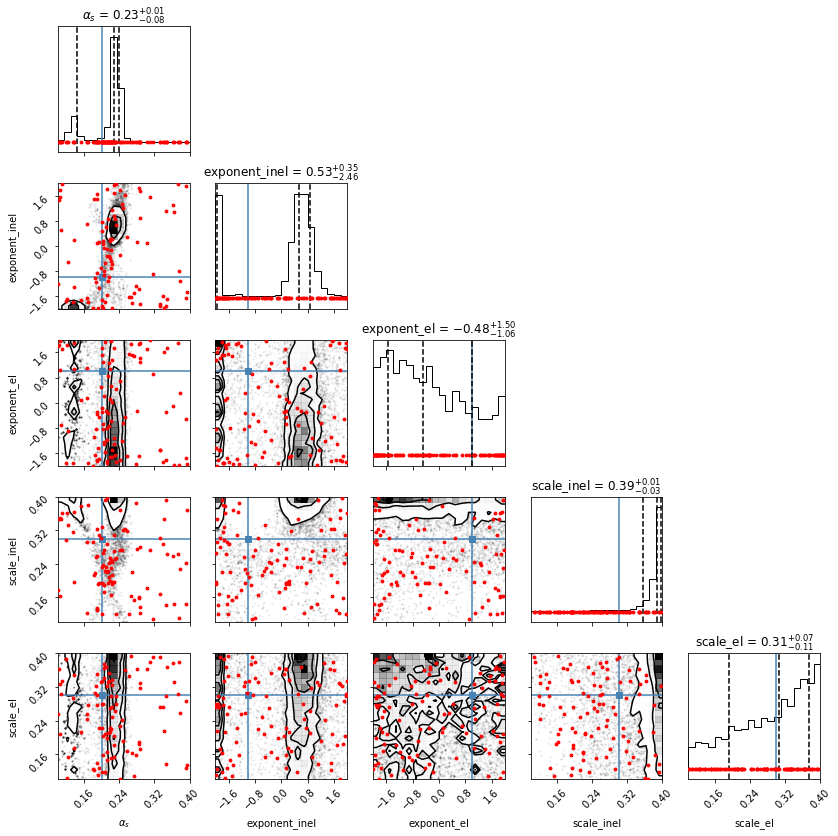

In [297]:
fig = corner.corner(chain_emu, quantiles=[0.16, 0.5, 0.84], truths=truth.T,
                    labels=[r"$\alpha_s$", 'exponent_inel', 'exponent_el','scale_inel','scale_el'], show_titles=True, scale_hist=True,
                    plot_contours=True, range=(prior_ranges.values()));

# Plot where forward model was evaluated
for row in range(0,5):
    for column in range(0,row+1):
        i=5*row+column
        if row == column:
            fig.axes[i].scatter(model_emukit.X[:,row],np.zeros(model_emukit.X[:,row].shape), s=8, color="red", zorder=20)
        else:
            fig.axes[i].scatter(model_emukit.X[:,column], model_emukit.X[:,row], s=8, color="red", zorder=20)

plt.tight_layout()
#plt.savefig('corner-expemulike-ptemcee-20ptLHS-expwt-divcovexp.png',dpi=600)
plt.show()

### This leads us to the obvious result: reducing the exponentiated IMSE.

Again we see that the exponentiation drives all other regions and their uncertainty to 0. Thus in order to do a better job, we need to write a method that exponentiates the GP before moving forward. As it stands, this result is pretty fantastic in that it behaves exactly as I expected and it still gets the peak quite close, but with such uncertainty as to be useless

We also see when we exponentiate that very few points are actually placed in regions of higher likelihood, but are rather scattered evenly across the loglikelihoods. This tells us very clearly where we expect these gains. 

Worth noting as well is that when the IMSE loglikelihood isn't very well trained, the biggest gains in the exponentiated IMSE will happen in regions that will actually have low likelihood, but this will at least start to remedy some of the bias. Really a mixed bag overall.
- scale_el is clearly mean-reverting because of how few relevant training points there are, especially when exponentiated. This means we should actually expect to resolve this behavior but aren't because of our emulation.
- exponent_el is biased, but again this appears to be an effect of the training points.

- Why not just emulate the likelihood and not the loglikelihood? Well, we want to exploit the exponentiation while also keeping our GP error constrained properly. Remember when we exponentiate we propagate the error band according to the variance rule, which is strictly speaking only for uncorrelated errors, so this is a weakness of the above plots.

For Simon: I think this points us in a direction where we have two existing methods which can be combined in a way that may work, but certainly isn't optimal. Even if we decide that a likelihood with GP error is difficult to interpret, it may be worth placing points using some sort of likelihood emulation but then training GPs on the observables at those points.

## Recall that in the loglikelihood emulation with standard IMSE, sklearn was better

Let's see if that holds again given that we're having trouble with overfitting in two parameters and I bet we have the points to fix it.

In [298]:
# Gaussian Process emulation
from sklearn.gaussian_process import GaussianProcessRegressor as GPR #for using Gaussian Processes
from sklearn.gaussian_process import kernels #same
from sklearn.preprocessing import StandardScaler #useful for scaling data

In [299]:
#this is the 'size' of possible variation of our parameters
ptp = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])\
-np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])

#This is our Squared Exponential Kernel
rbf_kern = 1. * kernels.RBF(
                      length_scale=ptp,
                      length_scale_bounds=np.outer(ptp, (1e-2, 1e5)),
                      )
#This is a white noise kernel, 
#necessary because our physics model has finite statistical accuracy
white_kern = kernels.WhiteKernel(
                         noise_level=.1,
                         noise_level_bounds=(1e-5, 1e1)
                        )

#our kernel is the sum of the Sq. Exponential and White Noise kernels
my_kernel = (rbf_kern + white_kern) 

In [300]:
#first scale our observables 
model_y_copy = Y.copy()
scaler = StandardScaler(copy=True).fit(model_y_copy.reshape(-1, 1))
scaled_model_y = scaler.transform(Y.reshape(-1, 1), copy=True) # the scaled model outputs

In [301]:
#maximizing the GP likelihood proceeds in an iterative process,
#beginning with a random seed. 
#We want to be sure we find a global max., so we restart it several times
nrestarts=100

#define our Gaussian process, and fit it to the hydro model calculations
my_gp = GPR(kernel=my_kernel,
         alpha=0.01, # the nugget, to stabilize matrix inversions
         n_restarts_optimizer=nrestarts, 
         ).fit(X, scaled_model_y)

In [302]:
def emu_predictskl(X):
    """This function handles the scaling and GP interpolation together, 
    returning our prediction in the ordinary observable space
    rather than the scaled observable space
    This map is what we call our 'emulator'. """
    scaled_y, scaled_dy = my_gp.predict(X, return_std=True)
    y = scaler.inverse_transform(scaled_y).reshape(len(X))
    dy = scaled_dy * scaler.scale_
    return y, dy

In [303]:
# Define the logprior function
def logPrior(theta):
    
    # Model parameters
    theta = np.array(theta)
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta 
    
    # Probability of model parameters: flat prior
    if prior_ranges['alpha_s'][0] < alpha_s < prior_ranges['alpha_s'][1] \
        and prior_ranges['exponent_inel'][0] < exp_inel < prior_ranges['exponent_inel'][1] \
        and prior_ranges['exponent_el'][0] < exp_el < prior_ranges['exponent_el'][1]\
        and prior_ranges['scale_inel'][0] < sc_inel < prior_ranges['scale_inel'][1] \
        and prior_ranges['scale_el'][0] < sc_el < prior_ranges['scale_el'][1]:
        return 0.0
    return -np.inf

In [304]:
def logemulikelihoodskl(theta,x, obs, obserr):
    theta = theta.reshape(-1,5)
    emulike = emu_predictskl(theta)#[0]
    #print(emulike)
    return emulike[0]

In [305]:
def logemuposterior(theta, x, obs, obserr):
        
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logemulikelihoodskl(theta,x, obs, obserr)

In [306]:
ntemps = 25
Tmax = 1e3

nwalkers = 10 #guidance is 10*d
ndim = 5
nburnin = 200
niterations= 1500
nthin = 1#0 # only record every nthin iteration

nthreads = 4

min_theta = np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])
max_theta = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])

# Data and uncertainties that we use to condition our model
args = (x, obs, obserr) # recall x = np.array(pT_obs)

ptsamplerskl=ptemcee.Sampler(nwalkers, ndim, logemulikelihoodskl, logPrior, ntemps, 
                  threads=nthreads, Tmax=Tmax, loglargs=args)

# Making the sampling multi-threaded is as simple as adding the threads=Nthreads 
# argument to PTSampler. 

# First, we run the sampler for 1000 burn-in iterations:
pos0 = np.random.uniform(min_theta, max_theta, (ntemps, nwalkers, ndim))

print("Running burn-in phase")
for p, lnprob, lnlike in ptsamplerskl.sample(pos0, iterations=nburnin,adapt=True):
    pass
ptsampler.reset()

print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:
for p, lnprob, lnlike in ptsamplerskl.sample(p, iterations=niterations, thin=nthin,adapt=True):
    pass 

print('Done MCMC')

mean_acc_frac = np.mean(ptsamplerskl.acceptance_fraction)
print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
      f"(in total {nwalkers*niterations} steps)")

Running burn-in phase
Running MCMC chains
Done MCMC
Mean acceptance fraction: 0.299 (in total 15000 steps)


In [307]:
chain_emuskl = ptsamplerskl.chain[0, :, :, :].reshape((-1, ndim))

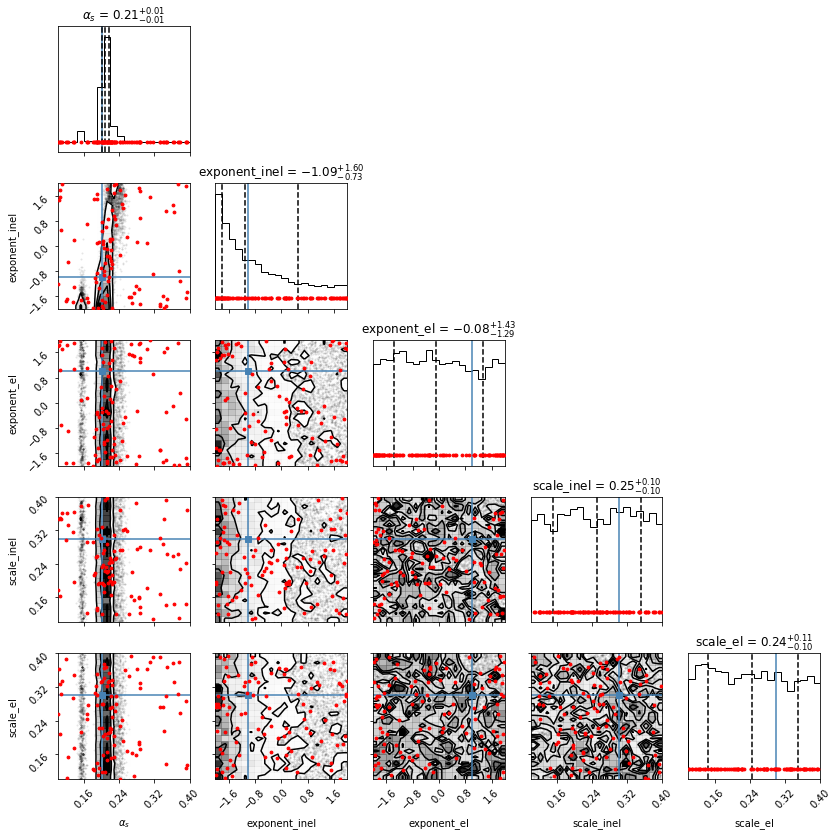

In [309]:
fig = corner.corner(chain_emuskl, quantiles=[0.16, 0.5, 0.84], truths=truth.T,
                    labels=[r"$\alpha_s$", 'exponent_inel', 'exponent_el','scale_inel','scale_el'], show_titles=True, scale_hist=True,
                    plot_contours=True, range=(prior_ranges.values()));

# Plot where forward model was evaluated
for row in range(0,5):
    for column in range(0,row+1):
        i=5*row+column
        if row == column:
            fig.axes[i].scatter(model_emukit.X[:,row],np.zeros(model_emukit.X[:,row].shape), s=8, color="red", zorder=20)
        else:
            fig.axes[i].scatter(model_emukit.X[:,column], model_emukit.X[:,row], s=8, color="red", zorder=20)


plt.tight_layout()
#plt.savefig('corner-expemulikeskl-ptemcee.png',dpi=600)
plt.show()

### All below here outdated

In [62]:
import time
for i in range(0,1):#range(0,10):
#model_variance = ModelVariance(model = model_emukit)
    gp = i%3
    print (f'Training {gp} gp for R_AA at {pT_obs[gp]} GeV')
    integrated_var = IntegratedVarianceReduction(model = gp_array[gp], space=parameter_space)
    expdesign_loop = ExperimentalDesignLoop(model = gp_array[gp],
                                         space = parameter_space,
                                         acquisition = integrated_var,
                                         batch_size = 4)
    ed=expdesign_loop.run_loop(funl[gp],1)
    
    X_latest=gp_array[gp].X[-10:,:]
    
    # we want to train the GP based on the exponentiated LogLikelihood function
    Y_latest= np.exp(fl(X_latest, pT=pT_obs))         
#     for k in range(0,0):
#         if k!=gp:
#             X = np.append(gp_array[k].X, X_latest, axis=0)
            
#             Y = np.append(gp_array[k].Y, Y_latest[:,k].reshape(-1,1), axis=0)
#             print(X.shape)
#             print(Y.shape)
#             gp_array[k].set_data(X, Y)
#             print(f'Optimizing the GP {k}')
#             print('\n before optimization')
#             print(gp_array[k].model)
#             st = time.time()
#             gp_array[k].optimize()
#             et = time.time()
#             print(f'Time it takes to do optimization {et-st}')
#             print('\n after optimization')
#             print(gp_array[k].model)

Training 0 gp for R_AA at 3 GeV
Optimization restart 1/30, f = 102.28286320681492
Optimization restart 2/30, f = 123.94223877965803
Warning - optimization restart 3/30 failed
Warning - optimization restart 4/30 failed
Warning - optimization restart 5/30 failed


 /home/mheffernan/anaconda3/lib/python3.8/site-packages/paramz/transformations.py:111: RuntimeWarning:overflow encountered in expm1
 /home/mheffernan/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:243: RuntimeWarning:invalid value encountered in true_divide
 /home/mheffernan/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /home/mheffernan/anaconda3/lib/python3.8/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Warning - optimization restart 6/30 failed
Warning - optimization restart 7/30 failed
Warning - optimization restart 8/30 failed
Optimization restart 9/30, f = 107.74900403203719
Warning - optimization restart 10/30 failed
Warning - optimization restart 11/30 failed
Warning - optimization restart 12/30 failed
Optimization restart 13/30, f = 107.74844218587576
Warning - optimization restart 14/30 failed
Optimization restart 15/30, f = 107.7489515764709
Optimization restart 16/30, f = 107.74899921466714
Optimization restart 17/30, f = 107.7486661738703
Warning - optimization restart 18/30 failed
Optimization restart 19/30, f = 107.74855554084778
Optimization restart 20/30, f = 118.19323619996058
Optimization restart 21/30, f = 107.74871283612983
Warning - optimization restart 22/30 failed
Warning - optimization restart 23/30 failed
Warning - optimization restart 24/30 failed
Warning - optimization restart 25/30 failed
Optimization restart 26/30, f = 118.19340265000449
Optimization restar

KeyboardInterrupt: 

In [22]:
def emu_predict0(X):
    y, variance_dy = gp_array[0].predict(X)
    dy = np.sqrt(variance_dy)
    #y = scaler_0.inverse_transform(scaled_y)
    #dy = scaled_dy* scaler_0.scale_
    return y, dy.flatten()

def emu_predict1(X):
    y, variance_dy = gp_array[1].predict(X)
    dy = np.sqrt(variance_dy)
    #y = scaler_0.inverse_transform(scaled_y)
    #dy = scaled_dy* scaler_0.scale_
    return y, dy.flatten()

def emu_predict2(X):
    y, variance_dy = gp_array[2].predict(X)
    dy = np.sqrt(variance_dy)
    #y = scaler_0.inverse_transform(scaled_y)
    #dy = scaled_dy* scaler_0.scale_
    return y, dy.flatten()

 <ipython-input-23-0afcc80287e4>:32: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


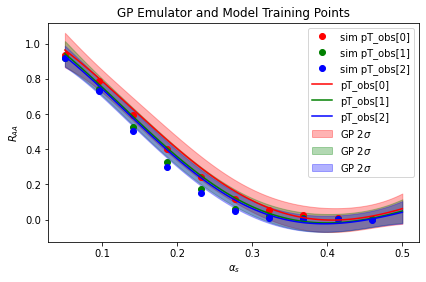

In [23]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points = np.array([[x,true_values['exponent_inel'],
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['alpha_s'][0],prior_ranges['alpha_s'][1],n_plot_pts)])
simulation_out = simulation(test_points[np.arange(0,n_plot_pts,sim_pnt),:],*pT_range)[:,pT_obs]
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),0], simulation_out[:,0],'ro', label='sim pT_obs[0]')
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),0], simulation_out[:,1],'go', label='sim pT_obs[1]')
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),0], simulation_out[:,2], 'bo', label='sim pT_obs[2]')


#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predict0(test_points)
gp_y1, gp_dy1 = emu_predict1(test_points)
gp_y2, gp_dy2 = emu_predict2(test_points)


plt.plot(test_points[:,0], gp_y0[:,0], color='red', label='pT_obs[0]')
plt.plot(test_points[:,0], gp_y1[:,0], color='green', label='pT_obs[1]')
plt.plot(test_points[:,0], gp_y2[:,0], color='blue', label='pT_obs[2]')
plt.fill_between(test_points[:,0], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')
plt.fill_between(test_points[:,0], y1 = gp_y1[:,0] - 2.*gp_dy1, y2 = gp_y1[:,0] + 2.*gp_dy1, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='green')
plt.fill_between(test_points[:,0], y1 = gp_y2[:,0] - 2.*gp_dy2, y2 = gp_y2[:,0] + 2.*gp_dy2, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='blue')

plt.xlabel(r'$\alpha_s$')
plt.ylabel(r'$R_{AA}$')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.tight_layout(True)

plt.show()

Working on 1/10 design


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning:dopri5: step size becomes too small
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning:dopri5: larger nsteps is needed
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning:The integral is probably divergent, or slowly convergent.
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning:The integral is probably divergent, or slowly convergent.


Working on 2/10 design
Working on 3/10 design
Working on 4/10 design
Working on 5/10 design
Working on 6/10 design
Working on 7/10 design
Working on 8/10 design
Working on 9/10 design
Working on 10/10 design


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


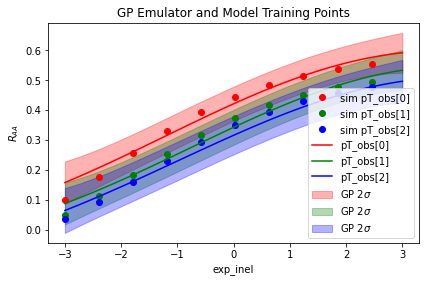

In [22]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points = np.array([[true_values['alpha_s'],x,
                 true_values['exponent_el'],true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['exponent_inel'][0],prior_ranges['exponent_inel'][1],n_plot_pts)])

simulation_out = simulation(test_points[np.arange(0,n_plot_pts,sim_pnt),:],*pT_range)[:,pT_obs]
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),1], simulation_out[:,0],'ro', label='sim pT_obs[0]')
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),1], simulation_out[:,1],'go', label='sim pT_obs[1]')
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),1], simulation_out[:,2], 'bo', label='sim pT_obs[2]')


#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predict0(test_points)
gp_y1, gp_dy1 = emu_predict1(test_points)
gp_y2, gp_dy2 = emu_predict2(test_points)

plt.plot(test_points[:,1], gp_y0[:,0], color='red', label='pT_obs[0]')
plt.plot(test_points[:,1], gp_y1[:,0], color='green', label='pT_obs[1]')
plt.plot(test_points[:,1], gp_y2[:,0], color='blue', label='pT_obs[2]')
plt.fill_between(test_points[:,1], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')
plt.fill_between(test_points[:,1], y1 = gp_y1[:,0] - 2.*gp_dy1, y2 = gp_y1[:,0] + 2.*gp_dy1, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='green')
plt.fill_between(test_points[:,1], y1 = gp_y2[:,0] - 2.*gp_dy2, y2 = gp_y2[:,0] + 2.*gp_dy2, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='blue')

plt.xlabel(r'exp_inel')
plt.ylabel(r'$R_{AA}$')
plt.title(r'GP Emulator and Model Training Points')
plt.legend()
plt.tight_layout(True)

plt.show()

Working on 1/10 design


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning:dopri5: step size becomes too small
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning:dopri5: larger nsteps is needed
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning:The integral is probably divergent, or slowly convergent.
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning:The integral is probably divergent, or slowly convergent.


Working on 2/10 design
Working on 3/10 design
Working on 4/10 design
Working on 5/10 design
Working on 6/10 design
Working on 7/10 design
Working on 8/10 design
Working on 9/10 design
Working on 10/10 design


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


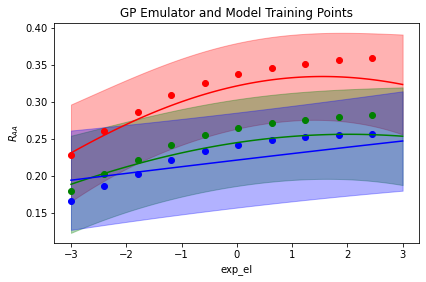

In [23]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points = np.array([[true_values['alpha_s'],true_values['exponent_inel'],
                 x,true_values['scale_inel'],true_values['scale_el']] for x in np.linspace(prior_ranges['exponent_el'][0],prior_ranges['exponent_el'][1],n_plot_pts)])

simulation_out = simulation(test_points[np.arange(0,n_plot_pts,sim_pnt),:],*pT_range)[:,pT_obs]
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),2], simulation_out[:,0],'ro', label='sim pT_obs[0]')
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),2], simulation_out[:,1],'go', label='sim pT_obs[1]')
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),2], simulation_out[:,2], 'bo', label='sim pT_obs[2]')


#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predict0(test_points)
gp_y1, gp_dy1 = emu_predict1(test_points)
gp_y2, gp_dy2 = emu_predict2(test_points)

plt.plot(test_points[:,2], gp_y0[:,0], color='red', label='pT_obs[0]')
plt.plot(test_points[:,2], gp_y1[:,0], color='green', label='pT_obs[1]')
plt.plot(test_points[:,2], gp_y2[:,0], color='blue', label='pT_obs[2]')
plt.fill_between(test_points[:,2], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')
plt.fill_between(test_points[:,2], y1 = gp_y1[:,0] - 2.*gp_dy1, y2 = gp_y1[:,0] + 2.*gp_dy1, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='green')
plt.fill_between(test_points[:,2], y1 = gp_y2[:,0] - 2.*gp_dy2, y2 = gp_y2[:,0] + 2.*gp_dy2, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='blue')

plt.xlabel(r'exp_el')
plt.ylabel(r'$R_{AA}$')
plt.title(r'GP Emulator and Model Training Points')
#plt.legend()
plt.tight_layout(True)

plt.show()

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning:dopri5: step size becomes too small


Working on 1/10 design


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning:dopri5: larger nsteps is needed
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning:The integral is probably divergent, or slowly convergent.
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning:The integral is probably divergent, or slowly convergent.


Working on 2/10 design
Working on 3/10 design
Working on 4/10 design
Working on 5/10 design
Working on 6/10 design
Working on 7/10 design
Working on 8/10 design
Working on 9/10 design
Working on 10/10 design


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


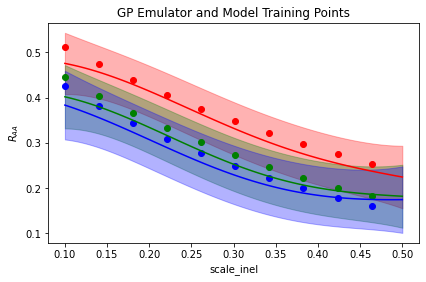

In [24]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points = np.array([[true_values['alpha_s'],true_values['exponent_inel'],
                 true_values['exponent_el'],x,true_values['scale_el']] for x in np.linspace(prior_ranges['scale_inel'][0],prior_ranges['scale_inel'][1],n_plot_pts)])

simulation_out = simulation(test_points[np.arange(0,n_plot_pts,sim_pnt),:],*pT_range)[:,pT_obs]
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),3], simulation_out[:,0],'ro', label='sim pT_obs[0]')
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),3], simulation_out[:,1],'go', label='sim pT_obs[1]')
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),3], simulation_out[:,2], 'bo', label='sim pT_obs[2]')


#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predict0(test_points)
gp_y1, gp_dy1 = emu_predict1(test_points)
gp_y2, gp_dy2 = emu_predict2(test_points)

plt.plot(test_points[:,3], gp_y0[:,0], color='red', label='pT_obs[0]')
plt.plot(test_points[:,3], gp_y1[:,0], color='green', label='pT_obs[1]')
plt.plot(test_points[:,3], gp_y2[:,0], color='blue', label='pT_obs[2]')
plt.fill_between(test_points[:,3], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')
plt.fill_between(test_points[:,3], y1 = gp_y1[:,0] - 2.*gp_dy1, y2 = gp_y1[:,0] + 2.*gp_dy1, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='green')
plt.fill_between(test_points[:,3], y1 = gp_y2[:,0] - 2.*gp_dy2, y2 = gp_y2[:,0] + 2.*gp_dy2, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='blue')

plt.xlabel(r'scale_inel')
plt.ylabel(r'$R_{AA}$')
plt.title(r'GP Emulator and Model Training Points')
#plt.legend()
plt.tight_layout(True)

plt.show()

 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning:dopri5: step size becomes too small
 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/scipy/integrate/_ode.py:1180: UserWarning:dopri5: larger nsteps is needed


Working on 1/10 design


 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:78: IntegrationWarning:The integral is probably divergent, or slowly convergent.
 /Users/dananjayaliyanage/git/parton_energy_loss_qcd_bjorken/solver_rk.py:73: IntegrationWarning:The integral is probably divergent, or slowly convergent.


Working on 2/10 design
Working on 3/10 design
Working on 4/10 design
Working on 5/10 design
Working on 6/10 design
Working on 7/10 design
Working on 8/10 design
Working on 9/10 design
Working on 10/10 design


 /Users/dananjayaliyanage/miniconda3/envs/parton_loss/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning:Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


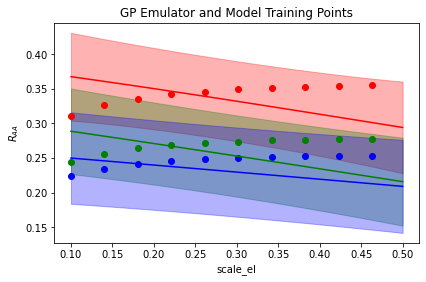

In [25]:
#make a regular grid to plot our Emulator predictions
n_plot_pts = 100
sim_pnt = 10
test_points = np.array([[true_values['alpha_s'],true_values['exponent_inel'],
                 true_values['exponent_el'],true_values['scale_inel'],x] for x in np.linspace(prior_ranges['scale_el'][0],prior_ranges['scale_el'][1],n_plot_pts)])

simulation_out = simulation(test_points[np.arange(0,n_plot_pts,sim_pnt),:],*pT_range)[:,pT_obs]
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),4], simulation_out[:,0],'ro', label='sim pT_obs[0]')
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),4], simulation_out[:,1],'go', label='sim pT_obs[1]')
plt.plot(test_points[np.arange(0,n_plot_pts,sim_pnt),4], simulation_out[:,2], 'bo', label='sim pT_obs[2]')


#get the GP Emulator's predictions of both the mean and std. deviation
gp_y0, gp_dy0 = emu_predict0(test_points)
gp_y1, gp_dy1 = emu_predict1(test_points)
gp_y2, gp_dy2 = emu_predict2(test_points)

plt.plot(test_points[:,4], gp_y0[:,0], color='red', label='pT_obs[0]')
plt.plot(test_points[:,4], gp_y1[:,0], color='green', label='pT_obs[1]')
plt.plot(test_points[:,4], gp_y2[:,0], color='blue', label='pT_obs[2]')
plt.fill_between(test_points[:,4], y1 = gp_y0[:,0] - 2.*gp_dy0, y2 = gp_y0[:,0] + 2.*gp_dy0, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='red')
plt.fill_between(test_points[:,4], y1 = gp_y1[:,0] - 2.*gp_dy1, y2 = gp_y1[:,0] + 2.*gp_dy1, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='green')
plt.fill_between(test_points[:,4], y1 = gp_y2[:,0] - 2.*gp_dy2, y2 = gp_y2[:,0] + 2.*gp_dy2, 
                 interpolate=True, alpha=0.3, label=r'GP 2$\sigma$', color='blue')

plt.xlabel(r'scale_el')
plt.ylabel(r'$R_{AA}$')
plt.title(r'GP Emulator and Model Training Points')
#plt.legend()
plt.tight_layout(True)

plt.show()

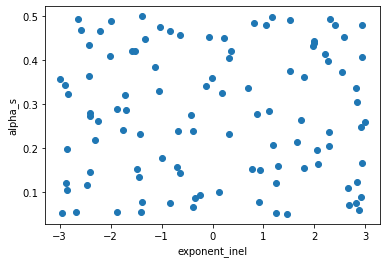

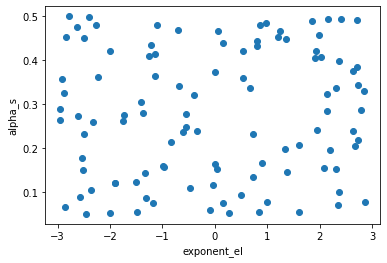

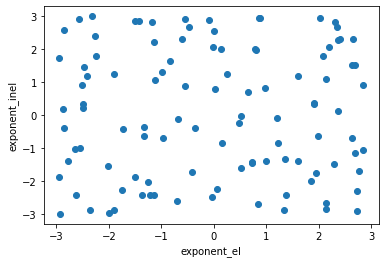

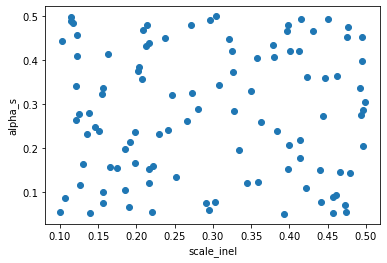

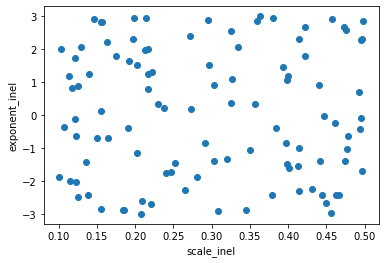

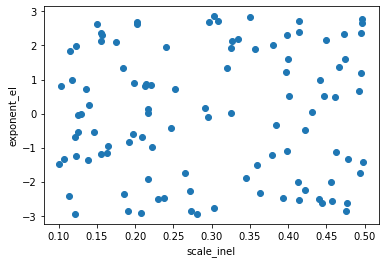

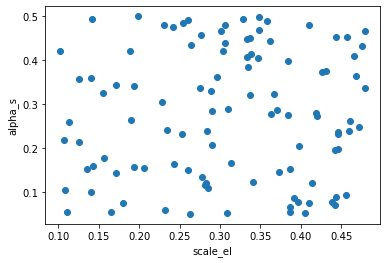

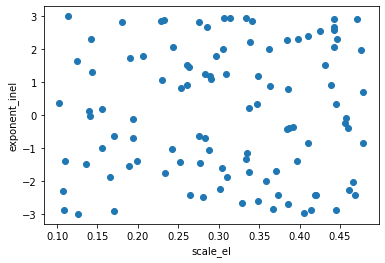

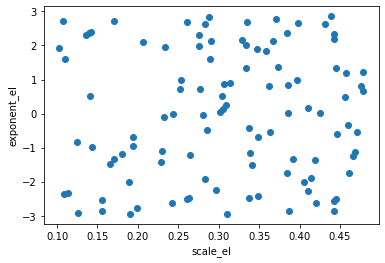

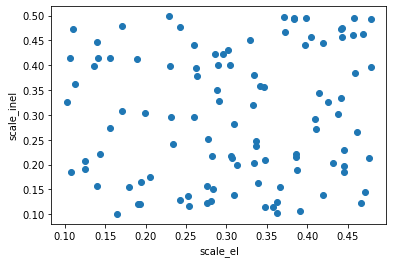

In [45]:
design = gp_array[0].X
for i in range(0,5):
    for k in range(0,i):
        fig, ax = plt.subplots()
        ax.scatter(design[:,i],design[:,k])
        ax.set_xlabel(f'{list(prior_ranges.keys())[i]}')
        ax.set_ylabel(f'{list(prior_ranges.keys())[k]}')

In [26]:
# Define the loglikelihood function
def logLikelihood(theta, x, obs, obserr):
  
    # Model parameters
    theta = np.array(theta)
    
    #alpha_s, mD_factor, exponent_inel, exponent_el = theta
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta
    design = np.array([alpha_s, exp_inel, exp_el, sc_inel, sc_el]).reshape(1,-1)
    
    # Model predictions given parameters
    
    model = np.array([emu_predict0(design),emu_predict1(design),emu_predict2(design)],dtype=object)
    modelerr = model[:,1]
    model = model[:,0]
    
    # Likelihood of data given model parameters

    term2 = 0.5*(2*np.pi*np.sqrt(np.sum(obserr**2+modelerr.flatten()**2)))
    return -0.5*np.sum((obs.flatten()-model.flatten())**2/(obserr**2+modelerr.flatten()**2)) - term2

In [27]:
logLikelihood(truth.flatten(),x,obs,obserr)

-1.0042884042986624

In [28]:
# Define the logprior function
def logPrior(theta):
    
    # Model parameters
    theta = np.array(theta)
    alpha_s, exp_inel, exp_el, sc_inel, sc_el = theta 
    
    # Probability of model parameters: flat prior
    if prior_ranges['alpha_s'][0] < alpha_s < prior_ranges['alpha_s'][1] \
        and prior_ranges['exponent_inel'][0] < exp_inel < prior_ranges['exponent_inel'][1] \
        and prior_ranges['exponent_el'][0] < exp_el < prior_ranges['exponent_el'][1]\
        and prior_ranges['scale_inel'][0] < sc_inel < prior_ranges['scale_inel'][1] \
        and prior_ranges['scale_el'][0] < sc_el < prior_ranges['scale_el'][1]:
        return 0.0
    return -np.inf

In [29]:
# Define logprobability function: l(D|theta) * p(theta)
# Note: use this for emcee, not approxposterior!
def logposterior(theta, x, obs, obserr):
        
    lp = logPrior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logLikelihood(theta, x, obs, obserr)

In [30]:
ntemps = 25
Tmax = 1e3

nwalkers = 50 #guidance is 10*d
ndim = 5
nburnin = 2000
niterations= 5000
nthin = 1#0 # only record every nthin iteration

nthreads = 4

min_theta = np.array([prior_ranges['alpha_s'][0],prior_ranges['exponent_inel'][0],prior_ranges['exponent_el'][0],prior_ranges['scale_inel'][0],prior_ranges['scale_el'][0]])
max_theta = np.array([prior_ranges['alpha_s'][1],prior_ranges['exponent_inel'][1],prior_ranges['exponent_el'][1],prior_ranges['scale_inel'][1],prior_ranges['scale_el'][1]])

# Data and uncertainties that we use to condition our model
args = (x, obs, obserr) # recall x = np.array(pT_obs)

ptsampler=ptemcee.Sampler(nwalkers, ndim, logLikelihood, logPrior, ntemps, 
                  threads=nthreads, Tmax=Tmax, loglargs=args)

# Making the sampling multi-threaded is as simple as adding the threads=Nthreads 
# argument to PTSampler. 

# First, we run the sampler for 1000 burn-in iterations:
pos0 = np.random.uniform(min_theta, max_theta, (ntemps, nwalkers, ndim))

print("Running burn-in phase")
for p, lnprob, lnlike in ptsampler.sample(pos0, iterations=nburnin,adapt=True):
    pass
ptsampler.reset()

print("Running MCMC chains")
#Now we sample for nwalkers*niterations, recording every nthin-th sample:
for p, lnprob, lnlike in ptsampler.sample(p, iterations=niterations, thin=nthin,adapt=True):
    pass 

print('Done MCMC')

mean_acc_frac = np.mean(ptsampler.acceptance_fraction)
print(f"Mean acceptance fraction: {mean_acc_frac:.3f}",
      f"(in total {nwalkers*niterations} steps)")

Running burn-in phase
Running MCMC chains
Done MCMC
Mean acceptance fraction: 0.301 (in total 250000 steps)


In [31]:
chain = ptsampler.chain[0, :, :, :].reshape((-1, ndim))


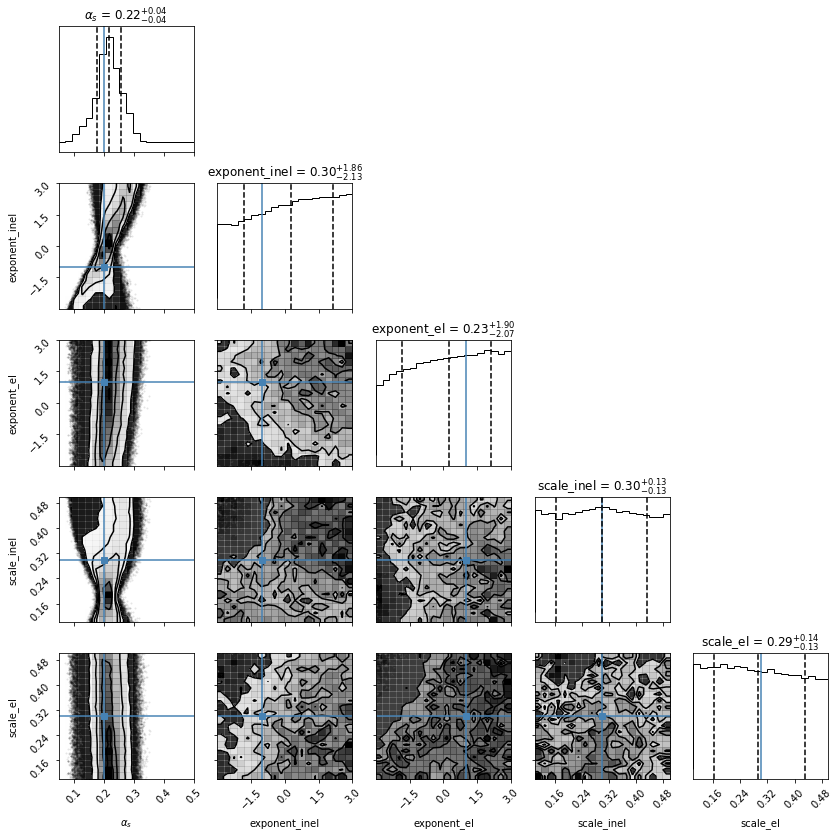

In [32]:
fig = corner.corner(chain, quantiles=[0.16, 0.5, 0.84], truths=truth.T,
                    labels=[r"$\alpha_s$", 'exponent_inel', 'exponent_el','scale_inel','scale_el'], show_titles=True, scale_hist=True,
                    plot_contours=True, range=(prior_ranges.values()));
plt.tight_layout()
plt.savefig('corner-lhsgp-ptemcee.png',dpi=600)
plt.show()

In [313]:
a = np.array([[0,1,2],[0,1,3]])

In [364]:
b = np.array([[0,1,2],[0,1,4],[0,1,2]])

In [365]:
a[b]

IndexError: index 2 is out of bounds for axis 0 with size 2

In [369]:
intsect = np.intersect1d(a,b)

In [370]:
c = (b==intsect)

In [371]:
c

array([[ True,  True,  True],
       [ True,  True, False],
       [ True,  True,  True]])

In [372]:
d = [x.all() for x in c]

In [373]:
b[d]

array([[0, 1, 2],
       [0, 1, 2]])

In [374]:
e = [not x for x in d]

In [375]:
b[e]

array([[0, 1, 4]])